# Visualización y Análisis del CLTV

Este notebook se centra en el análisis visual del Customer Lifetime Value (CLTV) calculado previamente, con el objetivo de:
- Identificación de patrones temporales en el valor del cliente
- Detección de segmentos de alto/bajo valor
- Relaciones entre variables drivers del CLTV
- ...

### Librerías

In [ ]:
# Generales y manejo de datos
import pandas as pd
import numpy as np
import os
import logging

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Conexión a SQL Server
import pyodbc  

### Conexion a la query del CLTV

In [30]:
# Configuración de logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Cadena de conexión
conn_str = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost;DATABASE=master;Trusted_Connection=yes;TrustServerCertificate=yes"

def execute_sql_query(connection_string, sql_query_path):
    """
    Ejecuta una consulta SQL desde un archivo y devuelve los resultados como DataFrame
    
    Args:
        connection_string: Cadena de conexión a la base de datos
        sql_query_path: Ruta al archivo con la consulta SQL
    
    Returns:
        DataFrame con los resultados o None si hay error
    """
    try:
        # Leer la consulta SQL del archivo
        with open(sql_query_path, 'r', encoding='utf-8') as f:
            sql_query = f.read().strip()
        
        # Conectar y ejecutar
        with pyodbc.connect(connection_string) as conn:
            # Ejecutar consulta y obtener resultados
            df = pd.read_sql(sql_query, conn)
            logging.info(f"Consulta ejecutada exitosamente. Filas obtenidas: {len(df)}")
            return df
            
    except pd.errors.DatabaseError as db_error:
        logging.error(f"Error en la consulta SQL: {db_error}")
    except Exception as e:
        logging.error(f"Error inesperado: {e}")
    return None

# Uso
if __name__ == "__main__":
    query_path = "../sql/CLTV/SQLQuery_CLTV.sql"
    logging.info(f"Ejecutando consulta desde: {query_path}")
    
    df_CLTV = execute_sql_query(conn_str, query_path)
    
    if df_CLTV is not None:
        print("\nPrimeras filas del resultado:")
        print(df_CLTV.head())

2025-03-29 00:53:29,342 - INFO - Ejecutando consulta desde: ../sql/CLTV/SQLQuery_CLTV.sql
C:\Users\aleja\AppData\Local\Temp\ipykernel_30052\2826530470.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)
2025-03-29 00:53:30,189 - INFO - Consulta ejecutada exitosamente. Filas obtenidas: 44227



Primeras filas del resultado:
   Customer_ID    Margen  Retencion  CLTV_Año1  CLTV_Año2  CLTV_Año3  \
0        37362  14246.78       0.95   12649.01    11278.7    9930.76   
1        44479  14246.78       0.95   12649.01    11278.7    9930.76   
2        39421  14246.78       0.95   12649.01    11278.7    9930.76   
3        70475  14246.78       0.95   12649.01    11278.7    9930.76   
4        44382  14246.78       0.95   12649.01    11278.7    9930.76   

   CLTV_Año4  CLTV_Año5  CLTV_Acum_1Año  CLTV_Acum_2Años  CLTV_Acum_3Años  \
0    8858.09     7874.2        12649.01         23927.71         33858.47   
1    8858.09     7874.2        12649.01         23927.71         33858.47   
2    8858.09     7874.2        12649.01         23927.71         33858.47   
3    8858.09     7874.2        12649.01         23927.71         33858.47   
4    8858.09     7874.2        12649.01         23927.71         33858.47   

   CLTV_Acum_4Años  CLTV_Acum_5Años  
0         42716.55         50590.76

## Visualizaciones

### 1. Distribución del CLTV a 5 años (Histograma + Densidad)

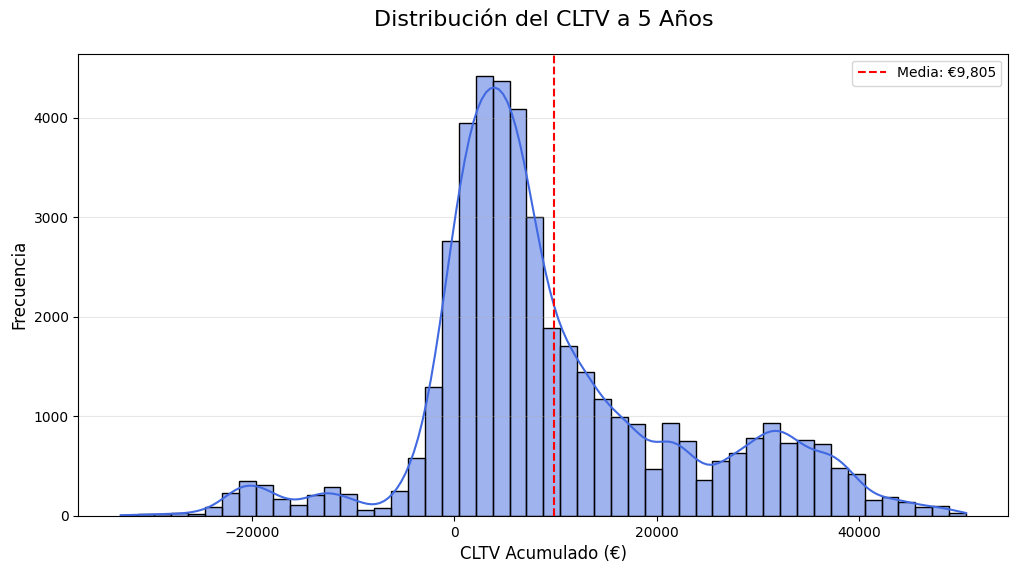

In [31]:
plt.figure(figsize=(12, 6))
sns.histplot(df_CLTV['CLTV_Acum_5Años'], bins=50, kde=True, color='royalblue')
plt.title('Distribución del CLTV a 5 Años', fontsize=16, pad=20)
plt.xlabel('CLTV Acumulado (€)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.axvline(df_CLTV['CLTV_Acum_5Años'].mean(), color='red', linestyle='--', 
            label=f'Media: €{df_CLTV["CLTV_Acum_5Años"].mean():,.0f}')
plt.legend()
plt.show()

### 2. Evolución del CLTV Promedio por Año (Gráfico de Líneas)

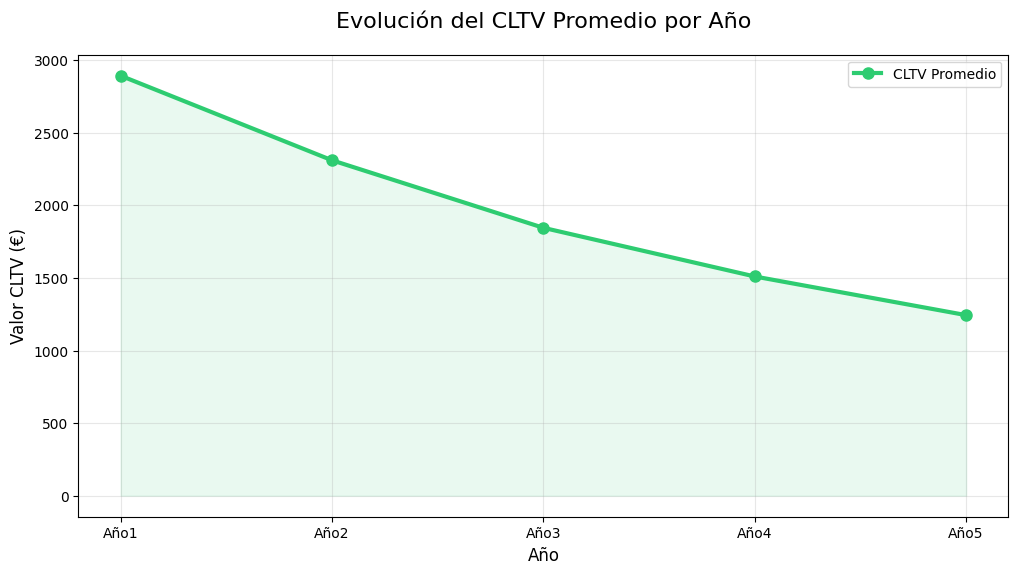

In [32]:
years = ['Año1', 'Año2', 'Año3', 'Año4', 'Año5']
cltv_avg = [df_CLTV[f'CLTV_{year}'].mean() for year in years]

plt.figure(figsize=(12, 6))
plt.plot(years, cltv_avg, marker='o', markersize=8, 
         color='#2ecc71', linewidth=3, label='CLTV Promedio')
plt.fill_between(years, cltv_avg, alpha=0.1, color='#2ecc71')
plt.title('Evolución del CLTV Promedio por Año', fontsize=16, pad=20)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Valor CLTV (€)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### 3. Valor Acumulado por Año (Gráfico de Área Apilada)

In [ ]:
acum_cols = ['CLTV_Acum_1Año', 'CLTV_Acum_2Años', 'CLTV_Acum_3Años', 
             'CLTV_Acum_4Años', 'CLTV_Acum_5Años']
acum_data = df_CLTV[acum_cols].mean().reset_index()
acum_data.columns = ['Año', 'Valor']

plt.figure(figsize=(12, 6))
plt.stackplot(range(1,6), 
             [df_CLTV[f'CLTV_Año{i}'].mean() for i in range(1,6)],
             labels=[f'Año {i}' for i in range(1,6)],
             colors=sns.color_palette("Blues", 5))
plt.plot(range(1,6), acum_data['Valor'], marker='o', color='darkblue', 
        linewidth=2.5, label='CLTV Acumulado')
plt.title('Contribución Anual al CLTV Acumulado', fontsize=16, pad=20)
plt.xlabel('Años', fontsize=12)
plt.ylabel('Valor CLTV (€)', fontsize=12)
plt.xticks(range(1,6))
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.show()

### 4. Segmentación de Clientes por Quintiles de CLTV

C:\Users\aleja\AppData\Local\Temp\ipykernel_30052\3651370076.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Quintil_CLTV', y='CLTV_Acum_5Años', data=df_CLTV,


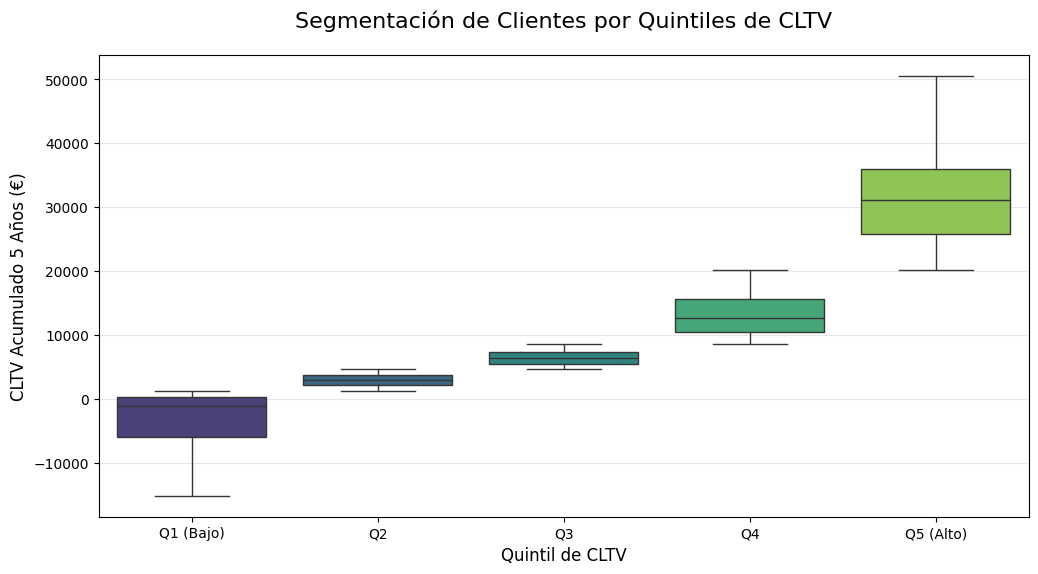

In [33]:
df_CLTV['Quintil_CLTV'] = pd.qcut(df_CLTV['CLTV_Acum_5Años'], q=5, 
                                 labels=['Q1 (Bajo)', 'Q2', 'Q3', 'Q4', 'Q5 (Alto)'])

plt.figure(figsize=(12, 6))
sns.boxplot(x='Quintil_CLTV', y='CLTV_Acum_5Años', data=df_CLTV, 
            palette='viridis', showfliers=False)
plt.title('Segmentación de Clientes por Quintiles de CLTV', fontsize=16, pad=20)
plt.xlabel('Quintil de CLTV', fontsize=12)
plt.ylabel('CLTV Acumulado 5 Años (€)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

### 5. Relación entre Margen y Retención (Scatter Plot con CLTV)

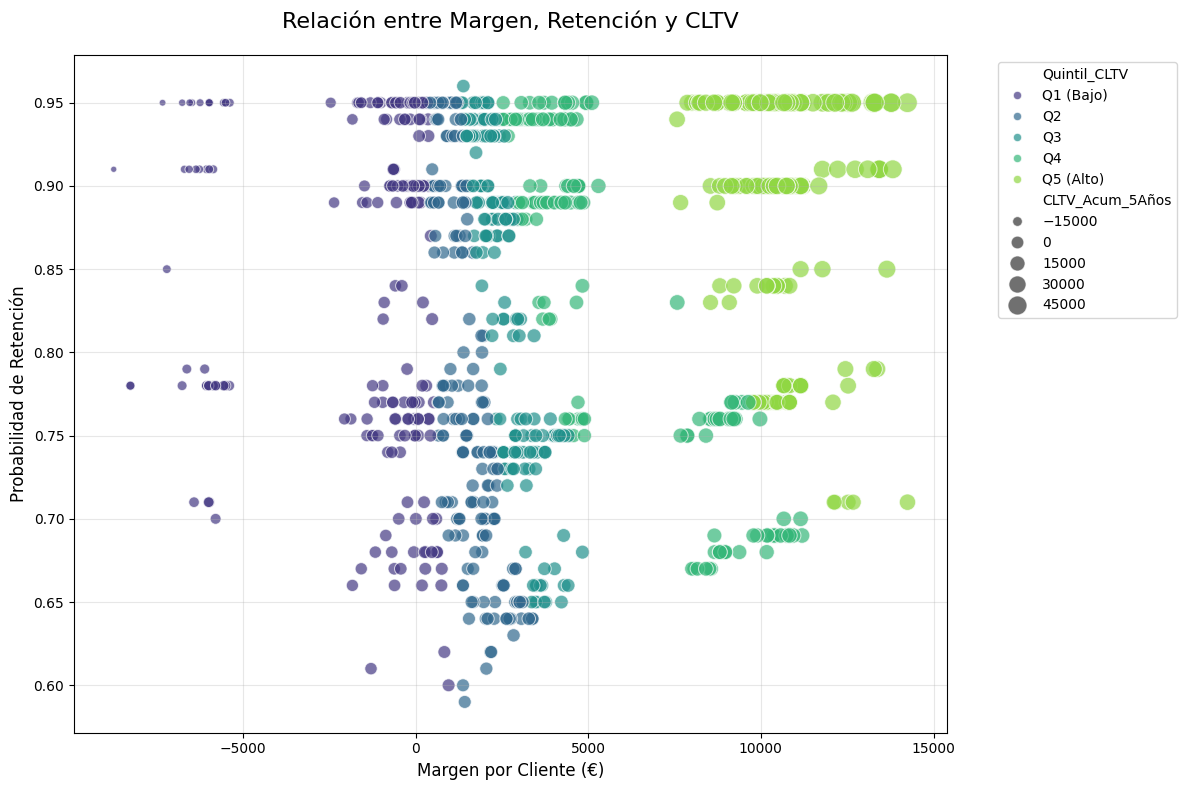

In [34]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Margen', y='Retencion', hue='Quintil_CLTV', 
                data=df_CLTV.sample(1000), palette='viridis', 
                size='CLTV_Acum_5Años', sizes=(20, 200), alpha=0.7)
plt.title('Relación entre Margen, Retención y CLTV', fontsize=16, pad=20)
plt.xlabel('Margen por Cliente (€)', fontsize=12)
plt.ylabel('Probabilidad de Retención', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 6. Top 10 Clientes por CLTV (Gráfico de Barras)

2025-03-29 00:58:51,514 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\aleja\AppData\Local\Temp\ipykernel_30052\2909040947.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CLTV_Acum_5Años', y='Customer_ID', data=top10, palette='rocket')
2025-03-29 00:58:51,527 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


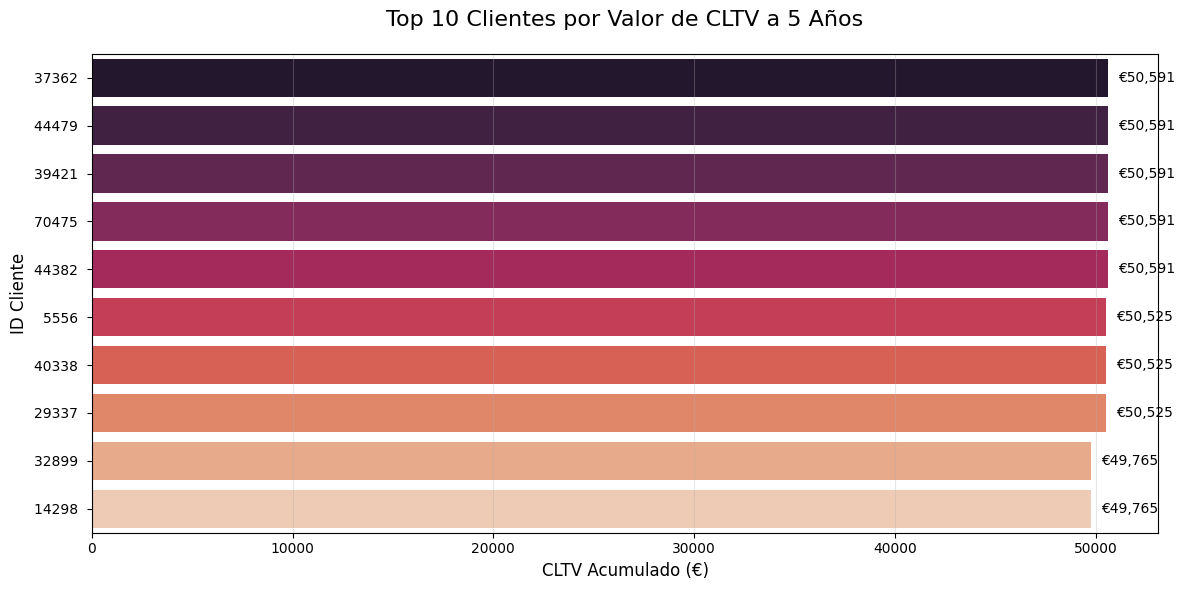

In [36]:
top10 = df_CLTV.nlargest(10, 'CLTV_Acum_5Años')[['Customer_ID', 'CLTV_Acum_5Años']]
top10['Customer_ID'] = top10['Customer_ID'].astype(str) + ' '  # Evitar notación científica

plt.figure(figsize=(12, 6))
sns.barplot(x='CLTV_Acum_5Años', y='Customer_ID', data=top10, palette='rocket')
plt.title('Top 10 Clientes por Valor de CLTV a 5 Años', fontsize=16, pad=20)
plt.xlabel('CLTV Acumulado (€)', fontsize=12)
plt.ylabel('ID Cliente', fontsize=12)
plt.grid(axis='x', alpha=0.3)
for i, v in enumerate(top10['CLTV_Acum_5Años']):
    plt.text(v + 500, i, f'€{v:,.0f}', color='black', va='center')
plt.tight_layout()
plt.show()

### 7. Matriz de Correlación (Heatmap)

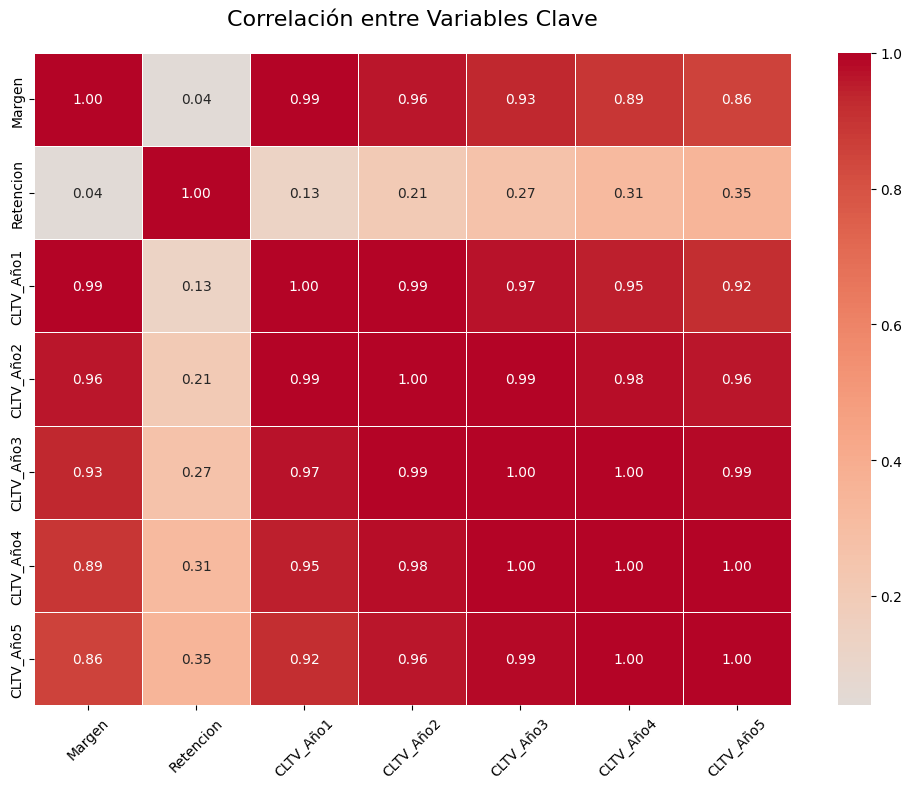

In [37]:
corr_cols = ['Margen', 'Retencion', 'CLTV_Año1', 'CLTV_Año2', 
             'CLTV_Año3', 'CLTV_Año4', 'CLTV_Año5']
corr_matrix = df_CLTV[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            center=0, linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlación entre Variables Clave', fontsize=16, pad=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()